# `qubit_discovery` Transmon Optimization

This notebook provides a demo on how to use `qubit_discovery` to optimize a flux-tunable transmon for a specific target frequency $\omega_{01}^*$, long $T_2$ time, and high anharmonicity. See the other tutorial notebooks for more details about the different functions used.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import qubit_discovery as qd
import SQcircuit as sq

1. Initialize a sampler to randomly sample circuits from allowed element ranges.

In [2]:
# Switch to the PyTorch engine
sq.set_engine('PyTorch')

# Construct circuit sampler
sampler = qd.CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0, 0.5]                 # in units of Phi_0
)

2. Construct loss function, using some built-in and some custom metrics. We'll optimize for
- A target qubit frequency of 6.5 GHz (a custom metric)
- Low sensitivity to external flux and charge (built-in).
- Long $T_2$ times and large anharmonicity $\alpha = \omega_{21} - \omega_{10}$. This is captured in a metric `'number_of_gates'` $\mathcal{N} = \alpha T_2$, which represents a bound on the number of single-qubit gates which can be performed $^\dagger$ (built-in).

<span style="font-size:0.8em;">

$^\dagger$ Actually, a better choice than $\alpha$ is the "gate speed"
$$ \mathcal{G} := \min_{i > 1}(\omega_{i0} - \omega_{10}, |\omega_{i0} - 2\omega_{10}|), $$
which we discuss in Appendix C of our paper [TODO]. For circuits with low anharmonicity, $\omega_{21} \approx \omega_{10}$ so $\mathcal{G} = \omega_{20} - 2\omega_{10} = \omega_{21} - \omega_{10} = \alpha$. However, $\mathcal{G}$ correctly accounts for circuits with very negative anharmonicity or densely packed excited states.

Hence, the `'number_of_gates'` metric is actually defined as $\mathcal{N} = \mathcal{G}T_2$.

</span>

In [3]:
# Construct a custom metric function for target frequency
TARGET_FREQUENCY = 6.5

def target_freq_loss(circuit):
    circuit_freq = circuit.efreqs[1] - circuit.efreqs[0]

    loss = ((circuit_freq - TARGET_FREQUENCY)/TARGET_FREQUENCY)**2
    return loss, circuit_freq

qd.add_to_metrics('target_frequency', target_freq_loss)


# Build total loss function 
# We pass in a dictionary with the components of the loss function and their
# weights.
my_loss_function = qd.build_loss_function(
    use_losses = { # setting all weights equal to 1.0 for this example
        'target_frequency': 1.0,
        'number_of_gates': 1.0,
        'charge_sensitivity': 1.0,
        'flux_sensitivity': 1.0
    }
)

3. Perform the optimization. Because gradient descent can get stuck in local minima, we run optimization 20 times with different random initializations.

Since BFGS automatically terminates when it reaches a local optima, don't worry if it stops before completing `max_iter` iterations.

In [4]:
optimization_results = []

for i in range(20):
    print(f'Optimizing circuit #{i+1}')
    # Sample a random starting point
    circuit = sampler.sample_circuit_code('JJ')

    # Perform the optimization
    res = qd.run_BFGS(
        circuit = circuit,
        loss_metric_function  = my_loss_function,
        max_iter = 50,
        total_trunc_num = 50,
        bounds = sampler.bounds,
    )

    # Save the output
    optimization_results.append(res)

Optimizing circuit #1


Iteration 12:  24%|██▍       | 12/50 [00:24<01:16,  2.01s/it, loss=3.067e-05]


Optimizing circuit #2


Iteration 18:  36%|███▌      | 18/50 [00:49<01:28,  2.76s/it, loss=2.231e-05]


Optimizing circuit #3


Iteration 18:  36%|███▌      | 18/50 [00:38<01:08,  2.13s/it, loss=3.816e-05]


Optimizing circuit #4


Iteration 21:  42%|████▏     | 21/50 [00:51<01:11,  2.46s/it, loss=2.262e-05]


Optimizing circuit #5


Iteration 49: 100%|██████████| 50/50 [01:11<00:00,  1.42s/it, loss=2.263e-05]


Optimizing circuit #6


Iteration 11:  22%|██▏       | 11/50 [00:32<01:56,  2.99s/it, loss=1.985e-05]


Optimizing circuit #7


Iteration 21:  42%|████▏     | 21/50 [00:46<01:04,  2.21s/it, loss=6.610e-05]


Optimizing circuit #8


Iteration 17:  34%|███▍      | 17/50 [00:37<01:12,  2.20s/it, loss=2.673e-05]


Optimizing circuit #9


Iteration 30:  60%|██████    | 30/50 [00:48<00:32,  1.61s/it, loss=5.310e-05]


Optimizing circuit #10


Iteration 25:  50%|█████     | 25/50 [01:00<01:00,  2.41s/it, loss=9.907e-05]


Optimizing circuit #11


Iteration 49: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it, loss=3.862e-05]


Optimizing circuit #12


Iteration 33:  66%|██████▌   | 33/50 [00:53<00:27,  1.63s/it, loss=7.078e-05]


Optimizing circuit #13


Iteration 49: 100%|██████████| 50/50 [01:29<00:00,  1.80s/it, loss=2.558e-05]


Optimizing circuit #14


Iteration 38:  76%|███████▌  | 38/50 [00:59<00:18,  1.55s/it, loss=5.596e-05]


Optimizing circuit #15


Iteration 10:  20%|██        | 10/50 [00:33<02:15,  3.39s/it, loss=5.495e-05]


Optimizing circuit #16


Iteration 26:  52%|█████▏    | 26/50 [00:47<00:43,  1.82s/it, loss=6.463e-05]


Optimizing circuit #17


Iteration 22:  44%|████▍     | 22/50 [00:48<01:02,  2.22s/it, loss=1.966e-05]


Optimizing circuit #18


Iteration 49: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it, loss=5.184e-05]


Optimizing circuit #19


Iteration 28:  56%|█████▌    | 28/50 [00:50<00:39,  1.81s/it, loss=4.074e-05]


Optimizing circuit #20


Iteration 14:  28%|██▊       | 14/50 [00:41<01:47,  2.98s/it, loss=5.269e-05]


4. We can now look at the best-performing optimizations. Let's start by plotting the learning curve of some of the runs.

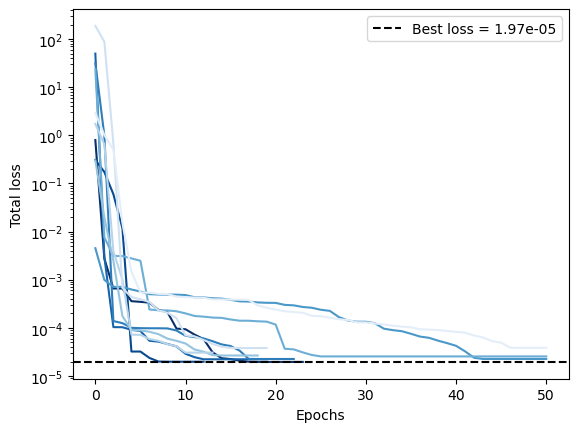

In [5]:
# Sort the results
optimization_results.sort()
best_run = optimization_results[0]

# Plot the best 10
cm = matplotlib.colormaps['Blues_r']
for i, res in enumerate(optimization_results[:10]):
    plt.semilogy(res.record['total_loss'], c=cm(i/10))

best_loss = best_run.loss
plt.axhline(best_loss, label=f'Best loss = {best_loss:.2e}', c='k', linestyle='--')
    
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.legend()

And now look at the details of the best circuit.

In [6]:
best_circuit = best_run.circuit

best_circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'Qubit frequency')

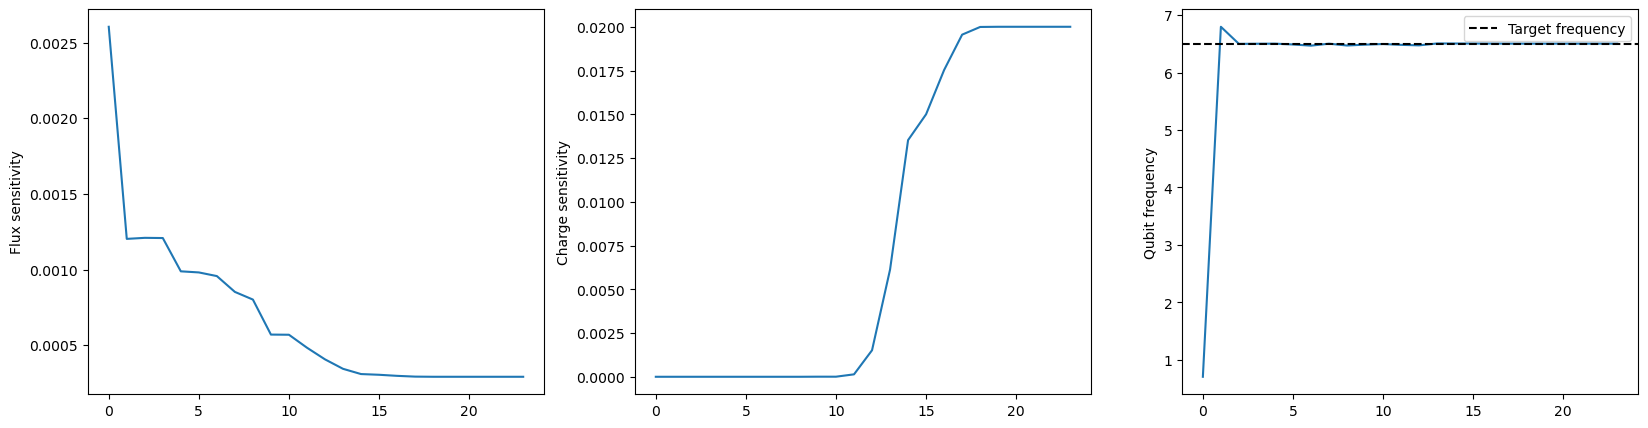

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(best_run.record['flux_sensitivity'])
ax[0].set_ylabel('Flux sensitivity')
ax[1].plot(best_run.record['charge_sensitivity'])
ax[1].set_ylabel('Charge sensitivity')
ax[2].plot(best_run.record['target_frequency'])
ax[2].axhline(TARGET_FREQUENCY, label='Target frequency', c='k', linestyle='--')
ax[2].legend()
ax[2].set_ylabel('Qubit frequency')